In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import re

import textwrap
wrapper = textwrap.TextWrapper(width=70)

tf.keras.utils.set_random_seed(10)

In [2]:
def get_train_test_data(data_dir):
    train_data = pd.read_json(f"{data_dir}/train.json")
    train_data.drop(['id'], axis=1, inplace=True)
    test_data = pd.read_json(f"{data_dir}/test.json")
    test_data.drop(['id'], axis=1, inplace=True)
    return train_data, test_data

In [3]:
def preprocess(input_data):
    def preprocess_util(input_data):
        lowercase = input_data.lower()
        removed_newlines = re.sub("\n|\r|\t", " ",  lowercase)
        removed_double_spaces = ' '.join(removed_newlines.split(' '))
        s = '[SOS] ' + removed_double_spaces + ' [EOS]'
        return s
    input_data['summary'] = input_data.apply(lambda row : preprocess_util(row['summary']), axis = 1)
    input_data['dialogue'] = input_data.apply(lambda row : preprocess_util(row['dialogue']), axis = 1)

    document = input_data['dialogue']
    summary = input_data['summary']
    
    return document, summary

In [4]:
data_dir = "data/corpus"

train_data, test_data = get_train_test_data(data_dir)

example_summary, example_dialogue = train_data.iloc[10]
print(f"Dialogue:\n{example_dialogue}")
print(f"\nSummary:\n{example_summary}")

Dialogue:
Lucas: Hey! How was your day?
Demi: Hey there! 
Demi: It was pretty fine, actually, thank you!
Demi: I just got promoted! :D
Lucas: Whoa! Great news!
Lucas: Congratulations!
Lucas: Such a success has to be celebrated.
Demi: I agree! :D
Demi: Tonight at Death & Co.?
Lucas: Sure!
Lucas: See you there at 10pm?
Demi: Yeah! See you there! :D

Summary:
Demi got promoted. She will celebrate that with Lucas at Death & Co at 10 pm.


In [5]:
document, summary = preprocess(train_data)
document_test, summary_test = preprocess(test_data)

In [6]:
filters = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n'
oov_token = '[UNK]'

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token, lower=False)

documents_and_summary = pd.concat([document, summary], ignore_index=True)

tokenizer.fit_on_texts(documents_and_summary)

inputs = tokenizer.texts_to_sequences(document)
targets = tokenizer.texts_to_sequences(summary)

vocab_size = len(tokenizer.word_index) + 1

print(f'Size of vocabulary: {vocab_size}')

Size of vocabulary: 34250


In [7]:
encoder_maxlen = 150
decoder_maxlen = 50

inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=decoder_maxlen, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32)

BUFFER_SIZE = 10000
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
def positional_encoding(positions, d_model):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int): Maximum number of positions to be encoded 
        d_model (int): Encoding size 
    
    Returns:
        pos_encoding (tf.Tensor): A matrix of shape (1, position, d_model) with the positional encodings
    """
    
    position = np.arange(positions)[:, np.newaxis]
    k = np.arange(d_model)[np.newaxis, :]
    i = k // 2
    angle_rates = 1 / np.power(10000, (2 * i) / np.float32(d_model))
    angle_rads = position * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [9]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        decoder_token_ids (matrix like): matrix of size (n, m)
    
    Returns:
        mask (tf.Tensor): binary tensor of size (n, 1, m)
    """    
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)
    return seq[:, tf.newaxis, :] 


def create_look_ahead_mask(sequence_length):
    """
    Returns a lower triangular matrix filled with ones
    
    Arguments:
        sequence_length (int): matrix size
    
    Returns:
        mask (tf.Tensor): binary tensor of size (sequence_length, sequence_length)
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask 

In [10]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q (tf.Tensor): query of shape (..., seq_len_q, depth)
        k (tf.Tensor): key of shape (..., seq_len_k, depth)
        v (tf.Tensor): value of shape (..., seq_len_v, depth_v)
        mask (tf.Tensor): mask with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        scaled_attention_logits += (1. - mask) * -1e9
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

In [11]:
q = np.array([[1, 1, 0, 1], [0, 1, 1, 1], [1, 0, 1, 1]]).astype(np.float32)
k = np.array([[1, 1, 0, 1], [1, 0, 1, 1 ], [1, 1, 1, 0], [0, 0, 0, 1], [0, 1, 0, 1]]).astype(np.float32)
v = np.array([[0, 0], [1, 0], [1, 0], [1, 1], [1, 1]]).astype(np.float32)
mask = np.array([[[0, 1, 0, 1, 1], [1, 0, 0, 1, 1], [1, 1, 0, 1, 1]]])

In [12]:
ou, atw = scaled_dot_product_attention(q, k, v, mask)
ou = np.around(ou, decimals=2)
atw = np.around(atw, decimals=2)

print(f"Output:\n {ou}")
print(f"\nAttention weigths:\n {atw}")

Output:
 [[[1.   0.62]
  [0.62 0.62]
  [0.74 0.31]]]

Attention weigths:
 [[[0.   0.38 0.   0.23 0.38]
  [0.38 0.   0.   0.23 0.38]
  [0.26 0.43 0.   0.16 0.16]]]


In [13]:
def FullyConnected(embedding_dim, fully_connected_dim):
    """
    Returns a sequential model consisting of two dense layers. The first dense layer has
    fully_connected_dim neurons and is activated by relu. The second dense layer has
    embedding_dim and no activation.

    Arguments:
        embedding_dim (int): output dimension
        fully_connected_dim (int): dimension of the hidden layer

    Returns:
        _ (tf.keras.Model): sequential model
    """
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),
        tf.keras.layers.Dense(embedding_dim)
    ])

In [14]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This architecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        
        super(EncoderLayer, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.ffn = FullyConnected(
            embedding_dim=embedding_dim,
            fully_connected_dim=fully_connected_dim
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            mask (tf.Tensor): Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            encoder_layer_out (tf.Tensor): Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """

        self_mha_output = self.mha(x, x, x, mask)
        skip_x_attention = self.layernorm1(x + self_mha_output)
        ffn_output = self.ffn(skip_x_attention)
        ffn_output = self.dropout_ffn(ffn_output, training=training)
        encoder_layer_out = self.layernorm2(skip_x_attention + ffn_output)

        return encoder_layer_out 

In [15]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """  
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.embedding_dim)
        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, seq_len, embedding_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            mask (tf.Tensor): Boolean mask to ensure that the padding is not 
                    treated as part of the input

        Returns:
            x (tf.Tensor): Tensor of shape (batch_size, seq_len, embedding_dim)
        """

        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training = training, mask = mask)

        return x

In [16]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks, 
    one that takes the new input and uses self-attention, and the other 
    one that combines it with the output of the encoder, followed by a
    fully connected block. 
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.mha2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.ffn = FullyConnected(
            embedding_dim=embedding_dim,
            fully_connected_dim=fully_connected_dim
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            enc_output (tf.Tensor): Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            out3 (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attn_weights_block1 (tf.Tensor): Tensor of shape (batch_size, num_heads, target_seq_len, target_seq_len)
            attn_weights_block2 (tf.Tensor): Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """
        
        mult_attn_out1, attn_weights_block1 = self.mha1(
            query=x, 
            value=x, 
            key=x, 
            attention_mask=look_ahead_mask, 
            training=training, 
            return_attention_scores=True)
        
        Q1 = self.layernorm1(mult_attn_out1 + x)

        mult_attn_out2, attn_weights_block2 = self.mha2(
            query=Q1, 
            value=enc_output, 
            key=enc_output, 
            attention_mask=padding_mask, 
            training=training, 
            return_attention_scores=True)
        
        Q2 = self.layernorm2(mult_attn_out2 + Q1)
        ffn_output = self.ffn(Q2)
        ffn_output = self.dropout_ffn(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + Q2)

        return out3, attn_weights_block1, attn_weights_block2

In [17]:
key_dim = 12
n_heads = 16

decoderLayer_test = DecoderLayer(embedding_dim=key_dim, num_heads=n_heads, fully_connected_dim=32)

q = np.ones((1, 15, key_dim))
encoder_test_output = tf.convert_to_tensor(np.random.rand(1, 7, 8))
look_ahead_mask = create_look_ahead_mask(q.shape[1])

out, attn_w_b1, attn_w_b2 = decoderLayer_test(q, encoder_test_output, training=False, look_ahead_mask=look_ahead_mask, padding_mask=None)

print(f"Using embedding_dim={key_dim} and num_heads={n_heads}:\n")
print(f"q has shape:{q.shape}")
print(f"Output of encoder has shape:{encoder_test_output.shape}\n")

print(f"Output of decoder layer has shape:{out.shape}")
print(f"Att Weights Block 1 has shape:{attn_w_b1.shape}")
print(f"Att Weights Block 2 has shape:{attn_w_b2.shape}")

Using embedding_dim=12 and num_heads=16:

q has shape:(1, 15, 12)
Output of encoder has shape:(1, 7, 8)

Output of decoder layer has shape:(1, 15, 12)
Att Weights Block 1 has shape:(1, 16, 15, 15)
Att Weights Block 2 has shape:(1, 16, 15, 7)


In [18]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Decoder starts by passing the target input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    decoder Layers
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder
        
        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output (tf.Tensor): Tensor of shape (batch_size, input_seq_len, embedding_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attention_weights (dict[str: tf.Tensor]): Dictionary of tensors containing all the attention weights
                                each of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training = training, look_ahead_mask = look_ahead_mask, padding_mask = padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1_self_att'] = block1
            attention_weights[f'decoder_layer{i+1}_block2_decenc_att'] = block2
        return x, attention_weights

In [19]:
n_layers = 5
emb_d = 13
n_heads = 17
fully_connected_dim = 16
target_vocab_size = 300
maximum_position_encoding = 6

x = np.array([[3, 2, 1, 1], [2, 1, 1, 0], [2, 1, 1, 0]])

encoder_test_output = tf.convert_to_tensor(np.random.rand(3, 7, 9))

look_ahead_mask = create_look_ahead_mask(x.shape[1])

decoder_test = Decoder(n_layers, emb_d, n_heads, fully_connected_dim, target_vocab_size,maximum_position_encoding)
                   
outd, att_weights = decoder_test(x, encoder_test_output, training= False, look_ahead_mask = look_ahead_mask, padding_mask = None)

print(f"Using num_layers={n_layers}, embedding_dim={emb_d} and num_heads={n_heads}:\n")
print(f"x has shape:{x.shape}")
print(f"Output of encoder has shape:{encoder_test_output.shape}\n")

print(f"Output of decoder has shape:{outd.shape}\n")
print("Attention weights:")
for name, tensor in att_weights.items():
    print(f"{name} has shape:{tensor.shape}")

Using num_layers=5, embedding_dim=13 and num_heads=17:

x has shape:(3, 4)
Output of encoder has shape:(3, 7, 9)

Output of decoder has shape:(3, 4, 13)

Attention weights:
decoder_layer1_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer1_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer2_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer2_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer3_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer3_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer4_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer4_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer5_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer5_block2_decenc_att has shape:(3, 17, 4, 7)


In [20]:
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')
    
    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            input_sentence (tf.Tensor): Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
                              An array of the indexes of the words in the input sentence
            output_sentence (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
                              An array of the indexes of the words in the output sentence
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask (tf.Tensor): Boolean mask to ensure that the padding is not 
                    treated as part of the input
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            dec_padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            final_output (tf.Tensor): The final output of the model
            attention_weights (dict[str: tf.Tensor]): Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        enc_output = self.encoder(x = input_sentence, training = training, mask = enc_padding_mask)

        dec_output, attention_weights = self.decoder(
            output_sentence, enc_output, training = training, look_ahead_mask = look_ahead_mask, padding_mask = dec_padding_mask
        )

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [21]:
n_layers = 3
emb_d = 13
n_heads = 17
fully_connected_dim = 8
input_vocab_size = 300
target_vocab_size = 350
max_positional_encoding_input = 12
max_positional_encoding_target = 12

transformer = Transformer(n_layers, 
    emb_d, 
    n_heads, 
    fully_connected_dim, 
    input_vocab_size, 
    target_vocab_size, 
    max_positional_encoding_input,
    max_positional_encoding_target)

sentence_a = np.array([[2, 3, 1, 3, 0, 0, 0]])
sentence_b = np.array([[1, 3, 4, 0, 0, 0, 0]])

enc_padding_mask = create_padding_mask(sentence_a)
dec_padding_mask = create_padding_mask(sentence_a)

look_ahead_mask = create_look_ahead_mask(sentence_a.shape[1])

test_summary, att_weights = transformer(
    sentence_a,
    sentence_b,
    training = False,
    enc_padding_mask = enc_padding_mask,
    look_ahead_mask = look_ahead_mask,
    dec_padding_mask = dec_padding_mask
)

print(f"Using num_layers={n_layers}, target_vocab_size={target_vocab_size} and num_heads={n_heads}:\n")
print(f"sentence_a has shape:{sentence_a.shape}")
print(f"sentence_b has shape:{sentence_b.shape}")

print(f"\nOutput of transformer (summary) has shape:{test_summary.shape}\n")
print("Attention weights:")
for name, tensor in att_weights.items():
    print(f"{name} has shape:{tensor.shape}")

Using num_layers=3, target_vocab_size=350 and num_heads=17:

sentence_a has shape:(1, 7)
sentence_b has shape:(1, 7)

Output of transformer (summary) has shape:(1, 7, 350)

Attention weights:
decoder_layer1_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer1_block2_decenc_att has shape:(1, 17, 7, 7)
decoder_layer2_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer2_block2_decenc_att has shape:(1, 17, 7, 7)
decoder_layer3_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer3_block2_decenc_att has shape:(1, 17, 7, 7)


In [22]:
num_layers = 2
embedding_dim = 128
fully_connected_dim = 128
num_heads = 2
positional_encoding_length = 256

transformer = Transformer(
    num_layers, 
    embedding_dim, 
    num_heads, 
    fully_connected_dim,
    vocab_size, 
    vocab_size, 
    positional_encoding_length, 
    positional_encoding_length,
)

In [23]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(embedding_dim)

optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

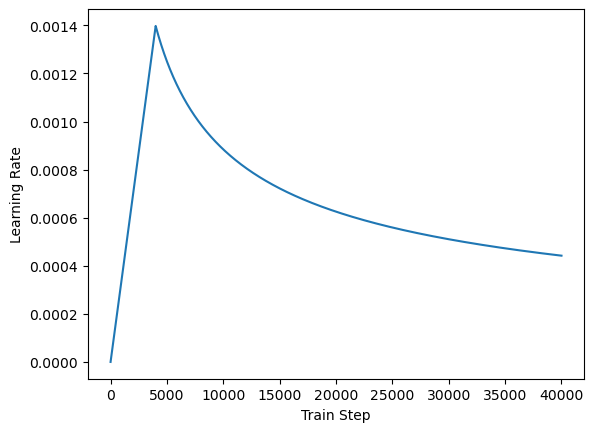

In [24]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [25]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

def masked_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')

losses = []

In [26]:
@tf.function
def train_step(model, inp, tar):
    """
    One training step for the transformer
    Arguments:
        inp (tf.Tensor): Input data to summarize
        tar (tf.Tensor): Target (summary)
    Returns:
        None
    """
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar_inp)[1])
    dec_padding_mask = create_padding_mask(inp)

    with tf.GradientTape() as tape:
        predictions, _ = model(
            inp,
            tar_inp, 
            training = True, 
            enc_padding_mask = enc_padding_mask, 
            look_ahead_mask = look_ahead_mask, 
            dec_padding_mask = dec_padding_mask
        )
        loss = masked_loss(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    return loss

In [27]:
def next_word(model, encoder_input, output):
    """
    Helper function for summarization that uses the model to predict just the next word.
    Arguments:
        encoder_input (tf.Tensor): Input data to summarize
        output (tf.Tensor): (incomplete) target (summary)
    Returns:
        predicted_id (tf.Tensor): The id of the predicted word
    """
    enc_padding_mask = create_padding_mask(encoder_input)
    look_ahead_mask = create_look_ahead_mask(tf.shape(output)[1])
    dec_padding_mask = create_padding_mask(encoder_input)

    predictions, _ = model(
        encoder_input,
        output,
        training=False,
        enc_padding_mask=enc_padding_mask,
        look_ahead_mask=look_ahead_mask,
        dec_padding_mask=dec_padding_mask
    )
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    return predicted_id


In [28]:
input_document = tokenizer.texts_to_sequences(["a random sentence"])
input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')
encoder_input = tf.expand_dims(input_document[0], 0)

output = tf.expand_dims([tokenizer.word_index["[SOS]"]], 0)

predicted_token = next_word(transformer, encoder_input, output)
print(f"Predicted token: {predicted_token}")

predicted_word = tokenizer.sequences_to_texts(predicted_token.numpy())[0]
print(f"Predicted word: {predicted_word}")

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Predicted token: [[1940]]
Predicted word: cancel


In [29]:
def summarize(model, input_document):
    """
    A function for summarization using the transformer model
    Arguments:
        input_document (tf.Tensor): Input data to summarize
    Returns:
        _ (str): The summary of the input_document
    """    
    input_document = tokenizer.texts_to_sequences([input_document])
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')
    encoder_input = tf.expand_dims(input_document[0], 0)
    
    output = tf.expand_dims([tokenizer.word_index["[SOS]"]], 0)
    
    for _ in range(decoder_maxlen):
        predicted_id = next_word(model, encoder_input, output)
        output = tf.concat([output, predicted_id], axis=-1)
        
        if predicted_id == tokenizer.word_index["[EOS]"]:
            break

    return tokenizer.sequences_to_texts(output.numpy())[0]  # since there is just one translated document

In [30]:
training_set_example = 0

print('Training set example:')
print(document[training_set_example])
print('\nHuman written summary:')
print(summary[training_set_example])
print('\nModel written summary:')
summarize(transformer, document[training_set_example])

Training set example:
[SOS] amanda: i baked  cookies. do you want some?  jerry: sure!  amanda: i'll bring you tomorrow :-) [EOS]

Human written summary:
[SOS] amanda baked cookies and will bring jerry some tomorrow. [EOS]

Model written summary:


"[SOS] cancel sixtynine sixtynine sixtynine advises graetful uoft sandstorm ellie's aligning aligning aligning aligning barb barb trimmings scaffoldings 128gb emerson prosecuted kayla's gabi acetone acetone bourgeois waitresses uninvited splitting success hurts calluses likke waitresses uninvited likke tuesdays eek miserable likke tuesdays eek tuesdays acetone labialized labialized riki honney likke uuu bred"

In [31]:
test_example = 0
true_summary = summary_test[test_example]
true_document = document_test[test_example]

epochs = 20

for epoch in range(epochs):

    start = time.time()
    number_of_batches=len(list(enumerate(dataset)))

    for (batch, (inp, tar)) in enumerate(dataset):
        print(f'Epoch {epoch+1}, Batch {batch+1}/{number_of_batches}', end='\r')
        loss = train_step(transformer, inp, tar)
        train_loss.update_state(loss)
    
    print (f'Epoch {epoch+1}, Loss {train_loss.result():.4f}')
    losses.append(train_loss.result())
    
    print (f'Time taken for one epoch: {time.time() - start} sec')
    print('Example summarization on the test set:')
    print('  True summarization:')
    print(f'    {true_summary}')
    print('  Predicted summarization:')
    print(f'    {summarize(transformer, true_document)}\n')

Epoch 1, Loss 7.892731
Time taken for one epoch: 131.35827565193176 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] and [EOS]

Epoch 2, Loss 7.233631
Time taken for one epoch: 224.80651211738586 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] is going to the the the new the new the new the new the new the new [EOS]

Epoch 3, Loss 6.825331
Time taken for one epoch: 191.1141800880432 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] tom is going to the new new new new new new new new new new new new new new new new new new new new new n

Text(0.5, 0, 'Epoch')

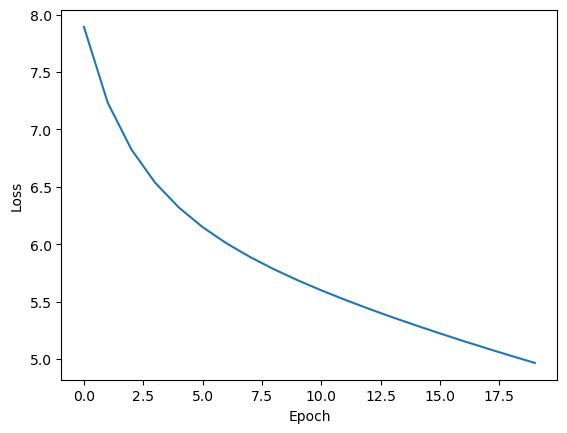

In [32]:
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [33]:
training_set_example = 0

print('Training set example:')
print(document[training_set_example])
print('\nHuman written summary:')
print(summary[training_set_example])
print('\nModel written summary:')
print(summarize(transformer, document[training_set_example]))

Training set example:
[SOS] amanda: i baked  cookies. do you want some?  jerry: sure!  amanda: i'll bring you tomorrow :-) [EOS]

Human written summary:
[SOS] amanda baked cookies and will bring jerry some tomorrow. [EOS]

Model written summary:
[SOS] amanda will bring some cookies tomorrow [EOS]


In [81]:
test_set_example = 3

print('Test set example:')
print(document_test[test_set_example])
print('\nHuman written summary:')
print(summary_test[test_set_example])
print('\nModel written summary:')
print(summarize(transformer, document_test[test_set_example]))

Test set example:
[SOS] will: hey babe, what do you want for dinner tonight?  emma:  gah, don't even worry about it tonight  will: what do you mean? everything ok?  emma: not really, but it's ok, don't worry about cooking though, i'm not hungry  will: well what time will you be home?  emma: soon, hopefully  will: you sure? maybe you want me to pick you up?  emma: no no it's alright. i'll be home soon, i'll tell you when i get home.   will: alright, love you.   emma: love you too.  [EOS]

Human written summary:
[SOS] emma will be home soon and she will let will know. [EOS]

Model written summary:


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


[SOS] emma will pick up emma for dinner tonight [EOS]


In [78]:
# transformer.save_weights('transformer.weights.h5')

In [79]:
# import keras

In [ ]:
# tf.keras.models.save_model(transformer, 'transformer_model.h5')

# def load_model_with_transformer(filepath):
#     def custom_object_scope():
#         return {'Transformer': type(transformer)}

#     with keras.utils.custom_object_scope(custom_object_scope()):
#         return tf.keras.models.load_model(filepath)

# loaded_transformer = load_model_with_transformer('transformer_model.h5')

In [70]:
# @keras.saving.register_keras_serializable()
# class Transformer(tf.keras.Model):
#     """
#     Complete transformer with an Encoder and a Decoder
#     """
#     def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
#                target_vocab_size, max_positional_encoding_input,
#                max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
#         super(Transformer, self).__init__()

#         self.encoder = Encoder(num_layers=num_layers,
#                                embedding_dim=embedding_dim,
#                                num_heads=num_heads,
#                                fully_connected_dim=fully_connected_dim,
#                                input_vocab_size=input_vocab_size,
#                                maximum_position_encoding=max_positional_encoding_input,
#                                dropout_rate=dropout_rate,
#                                layernorm_eps=layernorm_eps)

#         self.decoder = Decoder(num_layers=num_layers, 
#                                embedding_dim=embedding_dim,
#                                num_heads=num_heads,
#                                fully_connected_dim=fully_connected_dim,
#                                target_vocab_size=target_vocab_size, 
#                                maximum_position_encoding=max_positional_encoding_target,
#                                dropout_rate=dropout_rate,
#                                layernorm_eps=layernorm_eps)

#         self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')
    
#     def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
#         """
#         Forward pass for the entire Transformer
#         Arguments:
#             input_sentence (tf.Tensor): Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
#                               An array of the indexes of the words in the input sentence
#             output_sentence (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
#                               An array of the indexes of the words in the output sentence
#             training (bool): Boolean, set to true to activate
#                         the training mode for dropout layers
#             enc_padding_mask (tf.Tensor): Boolean mask to ensure that the padding is not 
#                     treated as part of the input
#             look_ahead_mask (tf.Tensor): Boolean mask for the target_input
#             dec_padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
#         Returns:
#             final_output (tf.Tensor): The final output of the model
#             attention_weights (dict[str: tf.Tensor]): Dictionary of tensors containing all the attention weights for the decoder
#                                 each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
#         """
#         enc_output = self.encoder(x = input_sentence, training = training, mask = enc_padding_mask)

#         dec_output, attention_weights = self.decoder(
#             output_sentence, enc_output, training = training, look_ahead_mask = look_ahead_mask, padding_mask = dec_padding_mask
#         )

#         final_output = self.final_layer(dec_output)

#         return final_output, attention_weights

# loaded_transformer = Transformer(
#     num_layers, 
#     embedding_dim, 
#     num_heads, 
#     fully_connected_dim,
#     vocab_size, 
#     vocab_size, 
#     positional_encoding_length, 
#     positional_encoding_length,
# )

# loaded_transformer.load_weights(r'H:\RAW Projects\Transformer-Summarizer\transformer.weights.h5')

In [ ]:
# test_set_example = 3

# print('Test set example:')
# print(document_test[test_set_example])
# print('\nHuman written summary:')
# print(summary_test[test_set_example])
# print('\nModel written summary:')
# print(summarize(loaded_transformer, document_test[test_set_example]))